# Federated Learning Template

In [ ]:
import numpy
import sklearn.metrics
import tensorflow
import time
import math

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
global n_client, nif, class_assignment, n_class, batch_size, random_seed, community_weight, client_weight
nif = 1
class_assignment = numpy.array([[0, 1], [2, 3], [4, 5], [6, 7]])
n_client = class_assignment.shape[0]
n_class = numpy.prod(class_assignment.shape)
batch_size = 32
random_seed = 29876
community_weight = 0.6
client_weight = 1 - community_weight

## Data

In [ ]:
"""Load CIFAR 10"""
(xraw_train, yraw_train), (xraw_test, yraw_test) = tensorflow.keras.datasets.cifar10.load_data()
yraw_train, yraw_test = yraw_train.flatten(), yraw_test.flatten()

xraw_train.shape, yraw_train.shape, xraw_test.shape, yraw_test.shape, xraw_train.dtype, xraw_train.max()

170498071/170498071 [==============================] - 4s 0us/step


((50000, 32, 32, 3),
 (50000,),
 (10000, 32, 32, 3),
 (10000,),
 dtype('uint8'),
 255)

In [ ]:
def get_labels(nif, labels, assignment, seed = None):
    """returns a list of ndarrays, the nth list contains bools to show which data are selected for the (n+1)th client.

    nif is the none independence factor. 0 means that the datasets returned for each client are completely independent from each other,
    while an nif of 1 means that all the clients have datasets from the same data distributions. for example, when nif is 0 and we have
    2 clients and four classes, the first client will only have data from two classes, while the second one only has data from the other
    two classes. if it takes on some value between 0 and 1: each dataset will contain more of the classes they are assigned in assignment,
    and some of the other classes.

    labels is the (either ndarray or list) of the labels in the training dataset.

    assignment is a (either a list of lists or ndarray) containing the labels for emphasized datasets of each client.
    eg. [[0, 1], [2, 3]] or [['cats', 'dogs'], ['frogs', 'pandas']]. these will be the datasets assigned to each client if nif equaled 0.
    the clients will be fed more data for these classes unless nif == 1.

    seed is the seed used for random functions, to make sure that identical results are obtainable.
    """
    #getting the length of labels and the number of clients
    if (type(labels) == list):
        labels = numpy.array(labels)
    n_data = labels.shape[0]
    assignment = numpy.array(assignment)


    #the different elements in labels
    if (type(assignment) == list):
        assignment = numpy.array(assignment)
    n_client = assignment.shape[0]
    nrlabels = assignment.reshape(-1)
    alpha = nif * (n_client - 1) / (1 + nif * n_client - nif)
    n_general = {}
    for i in nrlabels:
      n_general[i] = round(alpha / (n_client - 1) * numpy.sum(labels == i))
    results = []
    for i in range(n_client):
        results.append(numpy.full(labels.shape, False))


    #set the random seed
    if (seed != None):
        numpy.random.seed(seed)


    #assign data without repitition by shuffling
    for i in nrlabels:
        temp = numpy.array(numpy.where(labels == i)[0])
        numpy.random.shuffle(temp)
        for j in range(n_client):
            results[j][temp[j * n_general[i] : (j + 1) * n_general[i]]] = True
            if (numpy.in1d(i, assignment[j])):
                results[j][temp[n_client * n_general[i]:]] = True
    return results

In [ ]:
def map_labels(unmapped_labels):
  """change the original label (scale may varie from 0 to 10 or whatever depending on the dataset) into scale of number of classes. enabling one_hot."""
  temp = numpy.empty(class_assignment.max() + 1)
  for i, j in enumerate(class_assignment.reshape(-1).tolist()):
    temp[j] = i
  return temp[unmapped_labels]

In [ ]:
def unmap(mapped_labels):
  return class_assignment.reshape(-1)[mapped_labels.astype('int32')]

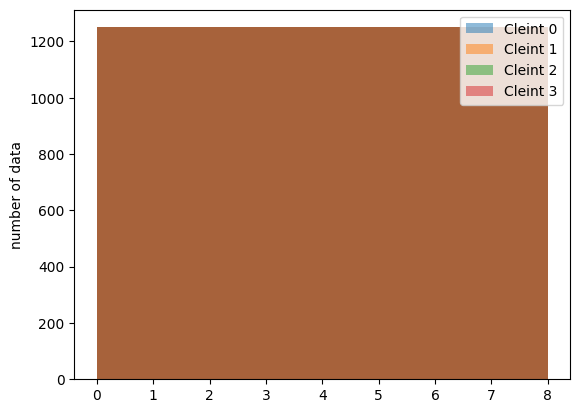

In [ ]:
"""Preprocess the data.

In addition, shuffle the data.
Set the random seed (so we can replicate the experiment).
"""


# Training Set
train_datasets = []
x_train_all = xraw_train.astype('float32').reshape(-1, 32, 32, 3)/255
train_labels = get_labels(nif, yraw_train, class_assignment, random_seed)
for i in range(n_client):
  y_temp = yraw_train[train_labels[i]]
  y_train = map_labels(y_temp)
  plt.hist(y_temp, alpha = 0.5, label = f'Cleint {i}', bins = numpy.array(range(0, 9)))
  plt.ylabel('number of data')
  train_datasets.append(tensorflow.data.Dataset.from_tensor_slices(
      (x_train_all[train_labels[i]], tensorflow.one_hot(y_train, n_class).numpy().astype('int32'))).shuffle(buffer_size = 1024, seed = random_seed).batch(batch_size))
y_train_all = tensorflow.one_hot(map_labels(yraw_train[numpy.isin(yraw_train, class_assignment.reshape(-1))]), n_class).numpy().astype('int32')
x_train_all = xraw_train[numpy.isin(yraw_train, class_assignment.reshape(-1))].astype('float32').reshape(-1, 32, 32, 3)/255
community_train_dataset = tensorflow.data.Dataset.from_tensor_slices((x_train_all, y_train_all))
community_train_dataset = community_train_dataset.shuffle(buffer_size=1024, seed=random_seed).batch(batch_size)
plt.legend()

# Validation Set
x_valid_all = xraw_test[numpy.isin(yraw_test, class_assignment.reshape(-1))].astype('float32').reshape(-1, 32, 32, 3)/255
y_valid_all = tensorflow.one_hot(map_labels(yraw_test[numpy.isin(yraw_test, class_assignment.reshape(-1))]), n_class).numpy().astype('int32')
valid_dataset = tensorflow.data.Dataset.from_tensor_slices((x_valid_all, y_valid_all)).batch(batch_size)

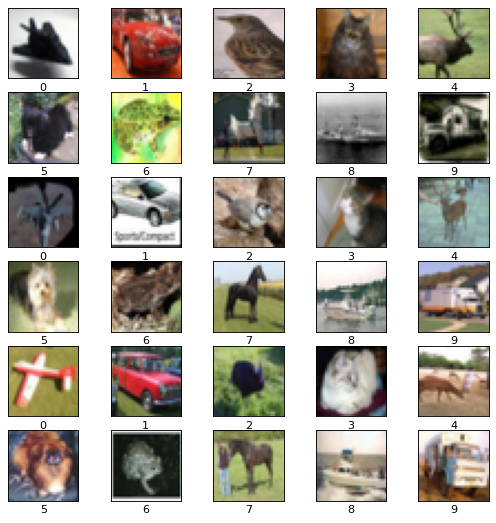

In [ ]:
"""Show examples."""
class_names = list(range(10))
offset = 1
one_batch = next(iter(valid_dataset.take(1)))

plt.figure(figsize=(8, 8), dpi=80)
for i in range(30):
    plt.subplot(6, 5, i+1)
    #x, y = one_batch
    x, y = xraw_train[yraw_train == (i % 10)][i], i % 10
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(x)#, cmap=plt.cm.binary)
    plt.xlabel(class_names[y])

plt.show()

## Training Class

In [ ]:
class Learner:

    def __init__(self, train_dataset, valid_dataset):
        """Initialization."""
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset

        self.model = self._build_model()
        self.optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.95)
        self.loss_function = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.train_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()
        self.valid_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()

        # Logs and counters
        self.training_batches = 0
        self.logs = []

    @staticmethod
    def _build_model():
        """Build model."""
        inputs = tensorflow.keras.Input(shape=(32, 32, 3), name="fashion")
        x = tensorflow.keras.layers.Conv2D(128, 5, activation='relu')(inputs)
        x = tensorflow.keras.layers.MaxPooling2D()(x)
        x = tensorflow.keras.layers.Conv2D(128, 7, activation='relu')(x)
        x = tensorflow.keras.layers.MaxPooling2D()(x)
        x = tensorflow.keras.layers.Flatten()(x)
        x = tensorflow.keras.layers.Dense(512, activation="relu")(x)
        outputs = tensorflow.keras.layers.Dense(n_class, name="predictions")(x)  # linear activation!
        return tensorflow.keras.Model(inputs=inputs, outputs=outputs, name=f'CustomModel')

    def train(self, batches=-1, log=False, verbose=False):
        """Train several batches."""
        start_time = time.time()

        loss_log = []
        for x_batch_train, y_batch_train in self.train_dataset.take(batches):
            self.training_batches += 1
            loss_value = self._train_step(x_batch_train, y_batch_train)
            loss_log.append(loss_value)
        mean_loss = numpy.mean(loss_log)

        train_acc = float(self.train_acc_metric.result())
        self.train_acc_metric.reset_states()

        if verbose:
            print(f'Training acc: {train_acc:.4f}')
            print(f'Time taken to complete training: {time.time() - start_time:.2f} s')
        if log:
            self.logs.append({
                'type': 'training', 'training_batches':  self.training_batches,
                'mean_training_loss': mean_loss, 'training_acccuracy': train_acc})

        return mean_loss, train_acc

    @tensorflow.function
    def _train_step(self, x, y):
        """Perform one step of training."""
        with tensorflow.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_function(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits)
        return loss_value

    def validate(self, log=False, verbose=False):
        """Validate model."""
        start_time = time.time()

        loss_log = []
        for x_batch_val, y_batch_val in self.valid_dataset:
            loss_value = self._valid_step(x_batch_val, y_batch_val)
            loss_log.append(loss_value)
        mean_loss = numpy.mean(loss_log)

        valid_acc = float(self.valid_acc_metric.result())
        self.valid_acc_metric.reset_states()

        if verbose:
            print(f'Validation acc: {valid_acc:.4f}')
            print(f'Time taken to complete validation: {time.time() - start_time:.2f} s')
        if log:
            self.logs.append({
                'type': 'validation', 'training_batches':  self.training_batches,
                'mean_validation_loss': mean_loss, 'vaidation_accuracy': valid_acc})

        return mean_loss, valid_acc

    @tensorflow.function
    def _valid_step(self, x, y):
        logits = self.model(x, training=False)
        self.valid_acc_metric.update_state(y, logits)
        return self.loss_function(y, logits)

    def get_confusion_matrix(self, verbose=False):
        """Prepare confussion matrix."""
        val_logits, val_labels = [], []
        for x_batch_val, y_batch_val in self.valid_dataset:
            logits = self.model(x_batch_val, training=False)
            val_logits.append(logits.numpy())
            val_labels.append(y_batch_val)
        val_logits = numpy.vstack(val_logits)
        val_labels = numpy.vstack(val_labels)

        val_logits = numpy.argmax(val_logits, axis=-1)
        val_labels = numpy.argmax(val_labels, axis=-1)

        # y axis shows true labels, x axis shows the predicted labels
        m = sklearn.metrics.confusion_matrix(
            y_true=val_labels, y_pred=val_logits,
            labels=unmap(numpy.arange(n_class)).tolist())

        if verbose:
            print('Accuracy:', sklearn.metrics.accuracy_score(val_logits, val_labels))

        return m

    def plot_weights_values(self, layer, xdim=None, scale=None, verbose=False, zoom=False):
        """Show the values of the weights in one layer."""
        weights = self.model.get_weights()[layer]
        if not scale:
            scale = numpy.abs(weights.flatten()).max()
        if xdim:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((xdim, -1))
        if len(weights.shape) != 2:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((-1, weights.shape[-1]))
        if zoom:
            a, b, c, d = zoom
            weights = weights[a:b,c:d]

        plt.figure(dpi=100, figsize=(5, 5))
        plt.imshow(weights, cmap='bwr', interpolation='none', vmin=-scale, vmax=scale)
        plt.show()

        if verbose:
            print(f'Scale from {-scale} to {scale}')
            nonzero = numpy.abs(weights.flatten()) > 10**(-5)
            print(f'Proportion of non-zero weights: {sum(nonzero)/len(nonzero)}')

## Federated Learning

In [ ]:
"""labels = numpy.argmax(y_train_all, axis=-1)
a = (labels == 0) | (labels == 1) | (labels == 2)
b = (labels == 3) | (labels == 4)
c = (labels == 5) | (labels == 6)
d = (labels == 7) | (labels == 8) | (labels == 9)"""

'labels = numpy.argmax(y_train_all, axis=-1)\na = (labels == 0) | (labels == 1) | (labels == 2)\nb = (labels == 3) | (labels == 4)\nc = (labels == 5) | (labels == 6)\nd = (labels == 7) | (labels == 8) | (labels == 9)'

In [ ]:
"""partial_train_dataset = {}
for i, s in enumerate([a, b, c, d]):
    partial_train_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_train_all[s], y_train_all[s])).shuffle(buffer_size=1024, seed=56).batch(batch_size)
"""
partial_valid_dataset = {}
for i in range(n_client + 1):
    n, k = 1_000*i, 1_000*(i+1)
    partial_valid_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_valid_all[n:k], y_valid_all[n:k])).batch(batch_size)

In [ ]:
client = {}
for i in range(n_client):
    client[i] = Learner(
        train_dataset=train_datasets[i],
        valid_dataset=partial_valid_dataset[i]
    )
PersonalLearner = Learner(
    train_dataset=train_datasets[0],
    valid_dataset=partial_valid_dataset[n_client]
)

In [ ]:
community = Learner(
    train_dataset=community_train_dataset,
    valid_dataset=valid_dataset
)

In [ ]:
co_weights = []
c1_weights = []
c2_weights = []
c3_weights = []
c4_weights = []
pl_weights = []

PersonalLearner.model.set_weights(community.model.get_weights())

for r in range(40):
    print(f'\n*** Round {r}')

    print(f'--- Distributing Weights Among Clients')
    for c in range(n_client):
        client[c].model.set_weights(community.model.get_weights())
    co_weights.append([c for c in zip(community.model.get_weights())])

    for c in range(n_client):
        print(f'--- Training Client {c}')
        client[c].train(verbose=True, log=True)
        client[c].validate(verbose=True, log=True)

    print('--- Training Personal Learner')
    PersonalLearner.train(verbose = True, log = True)
    PersonalLearner.validate(verbose = True, log = True)

    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    for c in range(n_client):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')
    averaged = [
        community_weight*c + client_weight*numpy.array(w).mean(axis=0)
        for c, w in zip(community.model.get_weights(), weights)]

    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)
    c1_weights.append([c for c in zip(client[0].model.get_weights())])
    c2_weights.append([c for c in zip(client[1].model.get_weights())])
    c3_weights.append([c for c in zip(client[2].model.get_weights())])
    c4_weights.append([c for c in zip(client[3].model.get_weights())])
    pl_weights.append([c for c in zip(PersonalLearner.model.get_weights())])


*** Round 0
--- Distributing Weights Among Clients
--- Training Client 0
Training acc: 0.2468
Time taken to complete training: 12.12 s
Validation acc: 0.3380
Time taken to complete validation: 0.30 s
--- Training Client 1
Training acc: 0.2539
Time taken to complete training: 2.16 s
Validation acc: 0.3500
Time taken to complete validation: 0.22 s
--- Training Client 2
Training acc: 0.2492
Time taken to complete training: 2.10 s
Validation acc: 0.3370
Time taken to complete validation: 0.21 s
--- Training Client 3
Training acc: 0.2558
Time taken to complete training: 2.64 s
Validation acc: 0.3320
Time taken to complete validation: 0.63 s
--- Training Personal Learner
Training acc: 0.2408
Time taken to complete training: 2.25 s
Validation acc: 0.3000
Time taken to complete validation: 0.24 s
--- Collecting Weights
--- Averaging Weights
--- Sending Weights to the Community Model 
Validation acc: 0.3209
Time taken to complete validation: 0.60 s

*** Round 1
--- Distributing Weights Among C

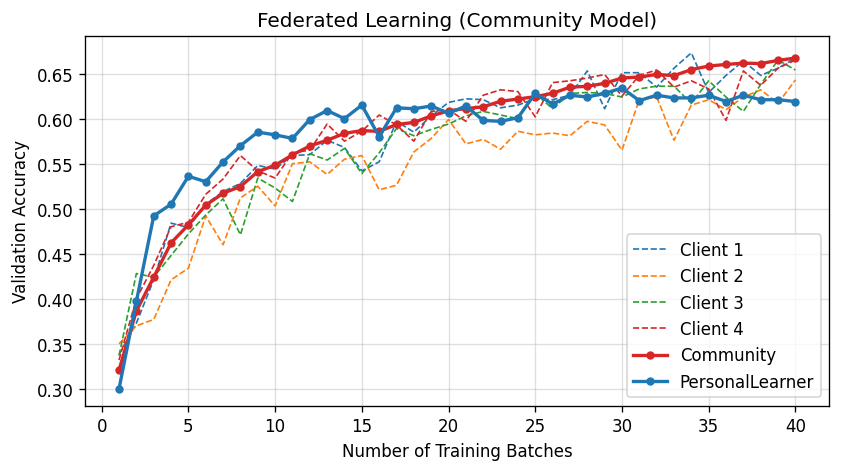

In [ ]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
ys = []
for i in range(n_client):
  ys.append([log['vaidation_accuracy'] for log in client[i].logs if log['type'] == 'validation'])
x = numpy.array(range(len(ys[0]))) + 1
for i in range(n_client):
  plt.plot(x, ys[i], '--', label=f'Client {i + 1}', lw=1)

# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

#PersonalLearner
y = [log['vaidation_accuracy'] for log in PersonalLearner.logs if log['type'] == 'validation']
x = numpy.array(range(len(y))) + 1
plt.plot(x, y, 'o-', color = 'tab:blue', label = 'PersonalLearner', lw = 2, ms = 4)

plt.title('Federated Learning (Community Model)')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Training Batches')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [ ]:
community.get_confusion_matrix(verbose = True)

Accuracy: 0.66725


array([[806,  54,  59,  21,  16,  11,  22,  11],
       [ 33, 904,   8,  21,   3,   5,  18,   8],
       [ 75,  16, 522,  75,  99,  73, 103,  37],
       [ 22,  27,  79, 480,  70, 164, 113,  45],
       [ 36,   5,  92,  65, 561,  49, 100,  92],
       [ 14,  11,  68, 201,  48, 542,  55,  61],
       [  7,  17,  47,  63,  29,  25, 805,   7],
       [ 21,  14,  29,  47,  65,  84,  22, 718]])

0.9936160380726871 0.9914590571523295 0.9936582038100745


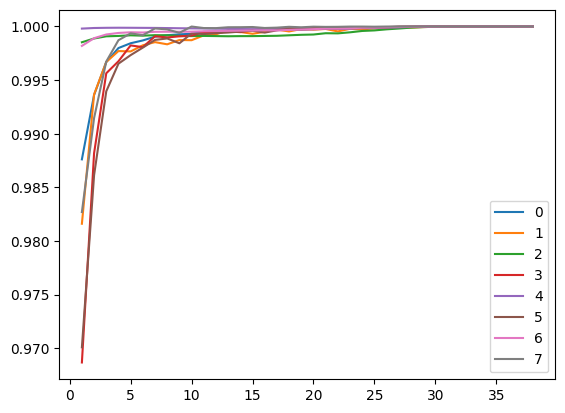

In [ ]:
a = [[] for i in range(8)]
x_list = range(1, 39)
for i in x_list:
  for j in range(8):
    a[j].append(numpy.dot(numpy.reshape(pl_weights[i][j], -1), numpy.reshape(pl_weights[i + 1][j], -1)) / math.sqrt(numpy.sum(numpy.square(pl_weights[i][j])) * numpy.sum(numpy.square(pl_weights[i + 1][j]))))
for i in range(8):
  plt.plot(x_list, a[i], label = f'{i}')
  plt.legend()
print(a[0][1], a[7][1], a[1][1])